# Store Profile Classifier

In [637]:
import pandas as pd
import numpy as np
import seaborn as sns

In [638]:
transactions = pd.read_csv("/kaggle/input/dataset/Historical-transaction-data.csv")
storedata = pd.read_csv("/kaggle/input/dataset/Store-info.csv")
testdata = pd.read_csv("/kaggle/input/dataset/Testing-data.csv")

In [639]:
transactions.head()

,item_description,transaction_date,invoice_id,customer_id,shop_id,item_price,quantity_sold
0,ORANGE BARLEY 1.5L,2021-12-11T00:00:00.000Z,147.0,BGXA,SHOP008,220,2
1,GINGER BEER 1.5L,2021-10-17T00:00:00.000Z,371.0,IA25,SHOP112,220,2
2,TONIC PET 500ML,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,160,2
3,CREAM SODA 1L,2021-12-13T00:00:00.000Z,484.0,VN7V,SHOP008,150,2
4,STRAWBERRY MILK 180ML,2021-10-23T00:00:00.000Z,1310.0,7S00,SHOP112,210,5


In [640]:
unique_shops = transactions['shop_id'].nunique()
print(unique_shops)

124


Basically there are 124 shops in total, we'll create a dataset from the transaction data

In [641]:
storedata

,shop_id,shop_area_sq_ft,shop_profile
0,SHOP047,528,Moderate
1,SHOP009,676,High
2,SHOP083,676,Low
3,SHOP117,676,Low
4,SHOP042,676,Low
...,...,...,...
119,SHOP087,527,NaN
120,SHOP050,411,NaN
121,SHOP061,699,NaN
122,SHOP056,597,NaN


# Planned Features
### Implemented
- Total Sales volume (total_vol)
- Total number of unique customers (total_customers)

### Not yet implemented
- Largest volume by date? Largest volume in a single day (single_day_max_vol) ?
- Smallest volume by date?
- Sales volume per square foot
- Number of recurring customers

### Target variable is shop_profile

## Adding total_vol

In [642]:
# Compute the total volume of transactions for each store_id in the dataset dataframe
total_vol_by_store = transactions.groupby('shop_id').apply(lambda x: (x['item_price'] * x['quantity_sold']).sum())

total_vol_by_store = total_vol_by_store.rename('total_vol')

# Merge the total_vol_by_store series with the storedata dataframe on the 'store_id' column
storedata = pd.merge(storedata, total_vol_by_store, on='shop_id', how='left')

storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol
0,SHOP047,528,Moderate,842960
1,SHOP009,676,High,1970870
2,SHOP083,676,Low,1691985
3,SHOP117,676,Low,2325980
4,SHOP042,676,Low,1340215
...,...,...,...,...
119,SHOP087,527,NaN,1128935
120,SHOP050,411,NaN,2399125
121,SHOP061,699,NaN,2110800
122,SHOP056,597,NaN,3023805


## Adding total_customers

In [643]:
# group the transactions dataframe by shop_id and count the number of unique customer_ids
unique_customers = transactions.groupby('shop_id')['customer_id'].nunique()

# add a new column to the storedata dataframe with the counts of unique customers
storedata['total_customers'] = storedata['shop_id'].map(unique_customers)

In [644]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,total_customers
0,SHOP047,528,Moderate,842960,928
1,SHOP009,676,High,1970870,2498
2,SHOP083,676,Low,1691985,1900
3,SHOP117,676,Low,2325980,2037
4,SHOP042,676,Low,1340215,1841
...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,1083
120,SHOP050,411,NaN,2399125,1778
121,SHOP061,699,NaN,2110800,1746
122,SHOP056,597,NaN,3023805,2832


## Adding single_day_max_vol

In [645]:
# assuming the transactions dataframe is already defined
transactions['single_day_max_vol'] = transactions['item_price'] * transactions['quantity_sold']
total_volume_per_day = transactions.groupby(['shop_id', 'transaction_date'])['single_day_max_vol'].sum().reset_index()
highest_volume_per_shop = total_volume_per_day.groupby('shop_id')['single_day_max_vol'].max().reset_index()

storedata = pd.merge(storedata, highest_volume_per_shop, on='shop_id')

In [646]:
storedata

,shop_id,shop_area_sq_ft,shop_profile,total_vol,total_customers,single_day_max_vol
0,SHOP047,528,Moderate,842960,928,71305
1,SHOP009,676,High,1970870,2498,85750
2,SHOP083,676,Low,1691985,1900,70610
3,SHOP117,676,Low,2325980,2037,82170
4,SHOP042,676,Low,1340215,1841,69185
...,...,...,...,...,...,...
119,SHOP087,527,NaN,1128935,1083,119750
120,SHOP050,411,NaN,2399125,1778,157410
121,SHOP061,699,NaN,2110800,1746,475215
122,SHOP056,597,NaN,3023805,2832,162465


## Checking Correlation

<AxesSubplot:>

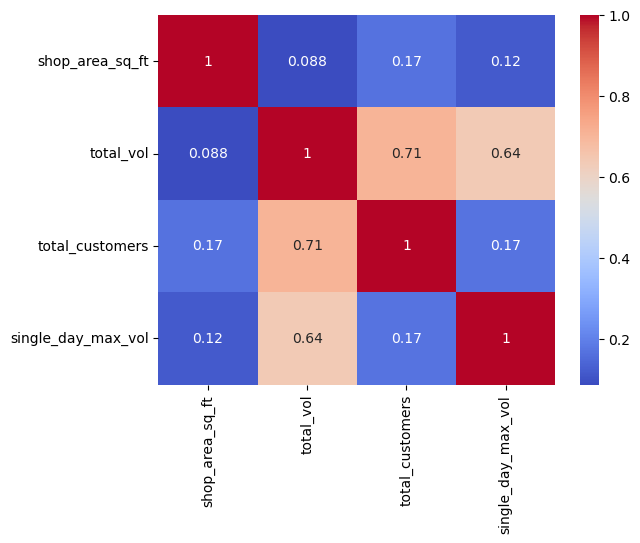

In [647]:
# create a correlation matrix
corr_matrix = storedata.corr()

# create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)

## Train test split (basically removing the testing data specified)

In [648]:
# Create a boolean mask for filtering shopdata
mask = storedata['shop_id'].isin(testdata['shop_id'])

# Create two separate dataframes
test_shops = storedata[mask]
train_shops = storedata[~mask]

In [649]:
test_shops = test_shops.drop('shop_profile', axis=1)
test_shops

,shop_id,shop_area_sq_ft,total_vol,total_customers,single_day_max_vol
100,SHOP046,545,2607865,1736,416450
101,SHOP024,676,1308795,1641,63695
102,SHOP023,617,2570425,2227,179010
103,SHOP097,310,2642380,1669,379995
104,SHOP044,715,1310440,1552,83410
105,SHOP030,530,2862995,1637,255825
106,SHOP038,411,1444025,1781,84285
107,SHOP029,597,1973805,2052,79130
108,SHOP096,676,2600915,2497,221065
109,SHOP092,617,1961240,2247,250855


In [650]:
train_shops

,shop_id,shop_area_sq_ft,shop_profile,total_vol,total_customers,single_day_max_vol
0,SHOP047,528,Moderate,842960,928,71305
1,SHOP009,676,High,1970870,2498,85750
2,SHOP083,676,Low,1691985,1900,70610
3,SHOP117,676,Low,2325980,2037,82170
4,SHOP042,676,Low,1340215,1841,69185
...,...,...,...,...,...,...
95,SHOP124,606,High,2967190,2281,409990
96,SHOP012,336,Low,1169405,1263,181610
97,SHOP093,705,High,1726515,1493,367595
98,SHOP004,516,Low,1571700,1744,67275


## Encoding the target variable 

### Ordinal encoding
0 = Low
1 = Moderate
2 = High

In [651]:
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None  # default='warn'

# Define the mapping of labels to integer codes
label_mapping = {
    'Low': 0,
    'Moderate': 1,
    'High': 2
}

# Create an instance of the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder to the shop_profile column in train_shops
train_shops['shop_profile'] = encoder.fit_transform(train_shops['shop_profile'].map(label_mapping))


In [652]:
train_shops

,shop_id,shop_area_sq_ft,shop_profile,total_vol,total_customers,single_day_max_vol
0,SHOP047,528,1,842960,928,71305
1,SHOP009,676,2,1970870,2498,85750
2,SHOP083,676,0,1691985,1900,70610
3,SHOP117,676,0,2325980,2037,82170
4,SHOP042,676,0,1340215,1841,69185
...,...,...,...,...,...,...
95,SHOP124,606,2,2967190,2281,409990
96,SHOP012,336,0,1169405,1263,181610
97,SHOP093,705,2,1726515,1493,367595
98,SHOP004,516,0,1571700,1744,67275


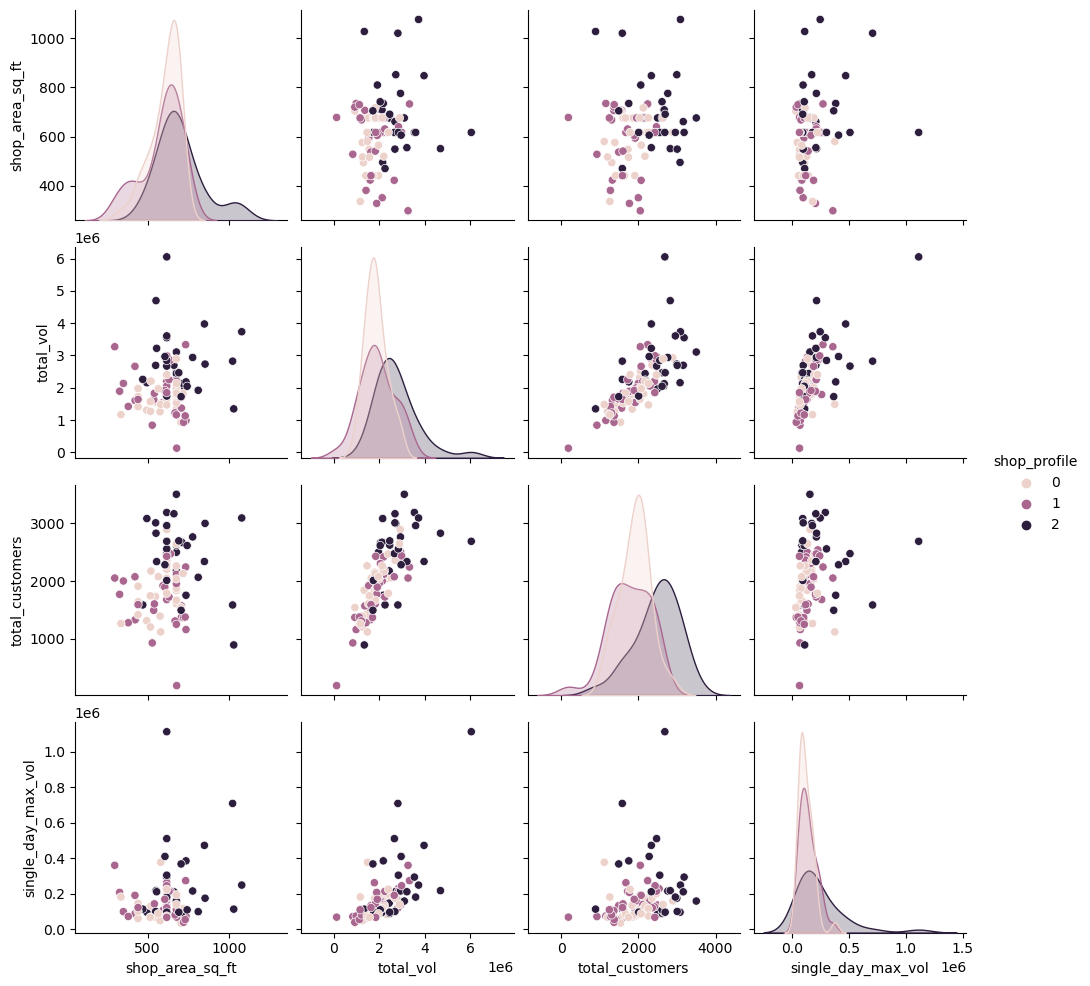

In [653]:
sns.pairplot(train_shops, hue='shop_profile')

## Spliting for crossvalidation

In [654]:
y = train_shops['shop_profile']
X = train_shops.drop('shop_profile', axis=1)
X = X.drop('shop_id',axis = 1)

In [655]:
y

0     1
1     2
2     0
3     0
4     0
     ..
95    2
96    0
97    2
98    0
99    2
Name: shop_profile, Length: 100, dtype: int64

In [656]:
X

,shop_area_sq_ft,total_vol,total_customers,single_day_max_vol
0,528,842960,928,71305
1,676,1970870,2498,85750
2,676,1691985,1900,70610
3,676,2325980,2037,82170
4,676,1340215,1841,69185
...,...,...,...,...
95,606,2967190,2281,409990
96,336,1169405,1263,181610
97,705,1726515,1493,367595
98,516,1571700,1744,67275


### Train test split

In [657]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

## Training the model

In [658]:
train_X

,shop_area_sq_ft,total_vol,total_customers,single_day_max_vol
48,720,931695,1370,39190
6,617,2946220,2496,136070
99,691,2465930,2695,95935
82,605,1917850,1894,168610
76,617,3606120,2959,180995
...,...,...,...,...
96,336,1169405,1263,181610
67,520,2206435,2172,130890
64,617,2671250,2474,510175
47,617,1791290,1678,261945


In [659]:
train_y

48    1
6     1
99    2
82    1
76    2
     ..
96    0
67    0
64    2
47    1
44    1
Name: shop_profile, Length: 75, dtype: int64

In [660]:
val_X

,shop_area_sq_ft,total_vol,total_customers,single_day_max_vol
26,594,1543645,1920,106095
86,441,1640080,1591,122105
2,676,1691985,1900,70610
55,661,2697370,3164,210680
75,549,2694095,3007,100090
93,555,3220950,2336,211115
16,495,2157105,3081,95865
73,541,1832065,1603,142890
54,617,2828540,2362,120770
95,606,2967190,2281,409990


In [661]:
val_y

26    1
86    1
2     0
55    2
75    2
93    2
16    2
73    1
54    1
95    2
53    2
92    0
78    1
13    1
7     1
30    2
22    2
24    0
33    0
8     0
43    1
62    2
3     0
71    1
45    0
Name: shop_profile, dtype: int64

### Training model

In [662]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [663]:
# Define the model with default hyperparameters
# model = XGBClassifier()
# model = KNeighborsClassifier(n_neighbors= 25)
model = RandomForestClassifier(n_estimators=100,random_state=1)

# Fit the model to the training data
model.fit(train_X, train_y)

RandomForestClassifier(random_state=1)

## Making predictions

In [664]:
# Make predictions on the test data
y_pred = model.predict(val_X)

## F1 Score

In [665]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(val_y, y_pred,average='micro')

# Print the result
print("F1 score:", f1)

F1 score: 0.56


## For submissions Train using full X and y sets

In [666]:
# Define the model with default hyperparameters
# FinalModel = XGBClassifier()
# FinalModel = KNeighborsClassifier(n_neighbors=3)
FinalModel = RandomForestClassifier(n_estimators=100,random_state=1)

# Fit the model to the training data
FinalModel.fit(train_X, train_y)

RandomForestClassifier(random_state=1)

In [667]:
test_shops = test_shops.drop('shop_id', axis=1)
test_shops

,shop_area_sq_ft,total_vol,total_customers,single_day_max_vol
100,545,2607865,1736,416450
101,676,1308795,1641,63695
102,617,2570425,2227,179010
103,310,2642380,1669,379995
104,715,1310440,1552,83410
105,530,2862995,1637,255825
106,411,1444025,1781,84285
107,597,1973805,2052,79130
108,676,2600915,2497,221065
109,617,1961240,2247,250855


In [668]:
FinalPred = FinalModel.predict(test_shops)

In [669]:
len(FinalPred)

24

## Combining predictions with shop_id

In [670]:
# Create a dictionary mapping the old values to the new values
mapping = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Map the values in the 'shop_profile' column using the dictionary
testdata["shop_profile"] = FinalPred

In [671]:
testdata

,shop_id,shop_profile
0,SHOP046,2
1,SHOP024,0
2,SHOP023,0
3,SHOP097,1
4,SHOP044,1
5,SHOP030,1
6,SHOP038,0
7,SHOP029,0
8,SHOP096,2
9,SHOP092,1


In [672]:
# Define a dictionary to map values to labels
label_map = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Replace the values in the shop_profile column with labels
testdata['shop_profile'] = testdata['shop_profile'].replace(label_map)

In [673]:
## Write to CSV
testdata.to_csv('output.csv', index=False)